# Анализ результатов A/B-теста

Задача — провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
* Оценить корректность проведения теста.
* Проанализировать результаты теста.

Чтобы оценить корректность проведения теста, проверить:
 * пересечение тестовой аудитории с конкурирующим тестом;
 * совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

#### Техническое задание

* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.

Загрузить данные теста, проверить корректность его проведения и проанализировать полученные результаты.

#### Описание данных

/datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;

Структура файла:
 - name — название маркетингового события;
 - regions — регионы, в которых будет проводиться рекламная кампания;
 - start_dt — дата начала кампании;
 - finish_dt — дата завершения кампании.

/datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Структура файла:
 - user_id — идентификатор пользователя;
 - first_date — дата регистрации;
 - region — регион пользователя;
 - device — устройство, с которого происходила регистрация.

/datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

Структура файла:
 - user_id — идентификатор пользователя;
 - event_dt — дата и время события;
 - event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

/datasets/final_ab_participants.csv — таблица участников тестов.

Структура файла:
 - user_id — идентификатор пользователя;
 - ab_test — название теста;
 - group — группа пользователя.

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import seaborn as sb
import os

In [2]:
#Функция для чтения таблиц
def read_table(name):
    pth1 = '/datasets/' + name + '.csv'
    pth2 = 'C:\\Users\\user\YandexDisk\Data analyst Yandex 2022\Проекты\Diploma AB\\' + name + '.csv'
    pth3 = 'F:/YandexDisk/Data analyst Yandex 2022/Проекты/Diploma AB/' + name +'.csv'

    if os.path.exists(pth1):
        table = pd.read_csv(pth1, sep=',', infer_datetime_format=True)
    elif os.path.exists(pth2):
        table = pd.read_csv(pth2, sep=',', infer_datetime_format=True)
    elif os.path.exists(pth3):
        table = pd.read_csv(pth3, sep=',', infer_datetime_format=True)
    else:
        print('Something is wrong - ', pth1)
        return
    return table

In [3]:
#Загружаем таблицы функцией read_table
marketing_events = read_table('ab_project_marketing_events')
users = read_table('final_ab_new_users')
users_events = read_table('final_ab_events')
participants = read_table('final_ab_participants')

datasets = [marketing_events, users, users_events, participants]

In [4]:
def describing_data(df):
    print('*'*50)
    display(df.head())
    print('*'*50)
    df.info()
    print('*'*50)
    display(df.describe())

In [5]:
describing_data(marketing_events)

**************************************************


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
**************************************************


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Black Friday Ads Campaign,APAC,2020-03-17,2020-03-10
freq,1,4,1,1


In [6]:
describing_data(users)

**************************************************


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
**************************************************


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,0C255F94348575ED,2020-12-21,EU,Android
freq,1,6290,46270,27520


In [7]:
describing_data(users_events)

**************************************************


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
**************************************************


,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


In [8]:
describing_data(participants)

**************************************************


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
**************************************************


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,9431D6C9475CFD3A,A,interface_eu_test
freq,2,9655,11567


In [9]:
#преобразуем даты для корректной сортировки
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt']).dt.date
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt']).dt.date
users['first_date'] = pd.to_datetime(users['first_date']).dt.date
users_events['event_dt'] = pd.to_datetime(users_events['event_dt'])

Пропуски обнаружены только в столбце `details` фрейма `users_events`. Эти пропуски не требуют обработки - столбец содержит дополнительную информацию о действиях пользователя

In [10]:
#проверим фреймы на явные дубликаты
for df in datasets:
    print(df.duplicated().sum())

0
0
0
0


In [11]:
#проверим наличие неявных дубликатов в категориальных столбцах
categorial = ['name', 'region', 'device', 'event_name', 'group', 'ab_test']
for df in datasets:
    for col in df:
        if col in categorial:
            display(df[col].value_counts())

Black Friday Ads Campaign           1
Dragon Boat Festival Giveaway       1
International Women's Day Promo     1
Chinese New Year Promo              1
Chinese Moon Festival               1
Victory Day CIS (May 9th) Event     1
Single's Day Gift Promo             1
Labor day (May 1st) Ads Campaign    1
Christmas&New Year Promo            1
St. Patric's Day Promo              1
CIS New Year Gift Lottery           1
4th of July Promo                   1
St. Valentine's Day Giveaway        1
Easter Promo                        1
Name: name, dtype: int64

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

A    9655
B    8613
Name: group, dtype: int64

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

Оценка корректности проведения теста

Проверим корректность всех пунктов технического задания.

1. Название теста: recommender_system_test

В проверке неявных дубликатов выше видно также наличие второго теста, который не имеет отношения к ТЗ. Удаляем его с созданием нового датафрейма.

In [12]:
participants_filtered = participants.query('ab_test == "recommender_system_test"')

2. Группы: А (контрольная), B (новая платёжная воронка)

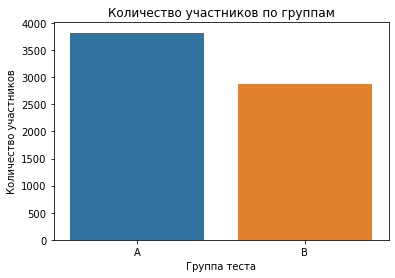

In [13]:
sb.barplot(x=participants_filtered.group.value_counts().index, y=participants_filtered.group.value_counts())
plt.title('Количество участников по группам')
plt.ylabel('Количество участников')
plt.xlabel('Группа теста')
plt.show()

3. Дата запуска: 2020-12-07

first_date в фрейме users должен быть больше или равен этой дате

In [14]:
users[users['first_date'] < pd.to_datetime("2020-12-07").date()]

,user_id,first_date,region,device


Подтверждено, пользователи с датой регистрации ранее 2012-12-07 отсутствуют

4. Дата остановки набора новых пользователей: 2020-12-21

first_date в фрейме users должен быть меньше или равен этой дате

In [15]:
users_test = participants_filtered['user_id'].unique()
users[users['first_date'] > pd.to_datetime("2020-12-21").date()].query('user_id in @users_test')['user_id'].nunique()

0

5. Дата остановки: 2021-01-04

Все события далее этой даты нас не интересуют

In [16]:
users_events[users_events['event_dt'] > pd.to_datetime("2021-01-04 23:59:59")]

,user_id,event_dt,event_name,details


Таких событий нет. Однако, нужно проверить когда реально закончился тест.

In [17]:
users_events[users_events['event_dt'] == max(users_events.merge(participants_filtered, on='user_id', how='right')['event_dt'])]

,user_id,event_dt,event_name,details
250743,DD4352CDCF8C3D57,2020-12-30 12:42:57,product_page,NaN


* тест остановлен ранее плановой даты, а он предполагал расчет метрик по пользователям на 14 день пользования сервисом. Или ресурс имеет крайне низкое удержание пользователей - и они просто перестали пользоваться сервисом до наступления конечной даты теста.

6. Аудитория: 15% новых пользователей из региона EU

Соединяем таблицы users и participants и проверяем долю пользователей по регионам и группам теста.

In [18]:
#соединяем все user_id со всеми отфильрованными участниками
data = users.merge(participants_filtered, on='user_id', how='outer')
#заполняем пропуски для тех user_id, что не попали в тест
data['group'] = data['group'].fillna('out_of_test')

In [19]:
#группируем пользователей из EU
eu_users_group = data.query('region == "EU"').groupby('group')['user_id'].agg('nunique').reset_index()

In [20]:
#рассчитываем относительные значения
eu_users_group['share'] = eu_users_group['user_id'] / sum(eu_users_group['user_id'])
eu_users_group.style.format({'share': '{:.1%}'})

,group,user_id,share
0,A,3634,7.9%
1,B,2717,5.9%
2,out_of_test,39919,86.3%


Совокупно, контрольная группа и группа с новой платежной воронкой занимают ровно 15% от всех новых польхователей в EU. Проверим также, не попали ли в тест пользователи не из EU.

In [21]:
data.query('region != "EU"').groupby('group')['user_id'].agg('nunique').reset_index()

,group,user_id
0,A,190
1,B,160
2,out_of_test,15113


Данные пользователи не должны входить в тест по условиям ТЗ. Удалим также и других пользователей не учавствовавших в тесте.

In [22]:
data = data.query('region == "EU"')
data = data.query('group in ["A", "B"]')

7. Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы.

Данный пункт проверить нет возможности - предполагаем, что мы имеем дело с верными данными

8. Ожидаемое количество участников теста: 6000

In [23]:
data.user_id.nunique()

6351

7. ожидаемый эффект будем проверять далее

Далее - время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.

In [24]:
marketing_events[marketing_events['regions'].str.contains("EU") & 
                 ((marketing_events['start_dt'] >= pd.to_datetime('2020-12-07')) &
                 (marketing_events['start_dt'] <= pd.to_datetime('2021-01-04'))) |
                 ((marketing_events['finish_dt'] >= pd.to_datetime('2020-12-07')) &
                 (marketing_events['finish_dt'] <= pd.to_datetime('2021-01-04')))
                  ]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


На время проведения теста приходится Christmas&New Year Promo в регионе EU. Так как мы пока не можем сказать, как эта акция влияла на группы пользователей, пока будем просто иметь в виду этот факт.

Проверим аудиторию теста. Конкурирующий тест удален нами ранее. Однако кто-то из пользователей мог участвовать одновременно  в обоих тестах. Проверим, есть ли такие.

In [25]:
participants.groupby('user_id')['ab_test'].agg('nunique').reset_index()['ab_test'].value_counts()

1    15064
2     1602
Name: ab_test, dtype: int64

1602 пользователя участвовали одновременно в обоих тестах. Т.к. это существенная часть данных исследуемого теста (25%), удалять их нельзя. Однако, зафиксируем этот факт как нарушение условий проведения теста.

Теперь проверим наличие пользователей, попавших в две группы теста одновременно.

In [26]:
data.groupby('user_id')['group'].agg('nunique').reset_index()['group'].value_counts()

1    6351
Name: group, dtype: int64

Таких пользователей не обнаружено

In [27]:
#добавляем к данным события по выбранным пользователям
data_full = data.merge(users_events, on='user_id', how='left')
#заполняем отсутствующие events предопределенным значением
data_full['event_name'] = data_full.event_name.fillna('register')
data_full.event_name.value_counts()

login           10595
product_page     6554
purchase         3196
product_cart     3075
register         2870
Name: event_name, dtype: int64

По части пользователей отстутствуют события. Это может быть по двум причинам. 
1) Данные пользователи зарегистрировались, но ни разу не заходили на сайт под зарегистированным логином. Т.е. это потери в конверсии между регистрацией и первым логином. 
2) Это может быть ошибка в сборе данных (например, нам не дали всех логов, или для этой группы пользователей логи вообще не записывались). 

Проверим, как менялось количество пользователей в группах  по дням.

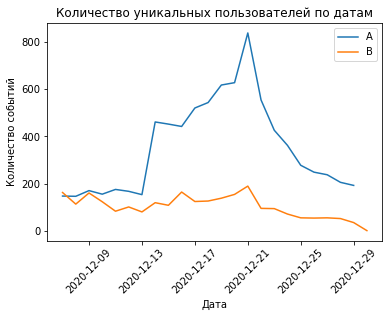

In [28]:
data_full['event_date'] = data_full['event_dt'].dt.date
dataA = data_full.query('group == "A"')
dataB = data_full.query('group == "B"')

plt.plot(dataA.groupby('event_date')['user_id'].agg('nunique'), label='A')
plt.plot(dataB.groupby('event_date')['user_id'].agg('nunique'), label='B')
plt.legend()
plt.xticks(rotation = '45')
plt.title('Количество уникальных пользователей по датам')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.show()

In [29]:
print('Всего пользователей ', data_full.user_id.nunique())
print('Пользователей без событий', data_full.query('event_name == "not defined"').user_id.nunique())

Всего пользователей  6351
Пользователей без событий 0


Пользователей без событий - почти половина. При этом есть существенный всплеск по новым пользователям в середине теста в группе A. Это говорит в пользу второй версии - возможно, части данных недостает. Однако, выборка по по количеству пользователей идеально соответствует ТЗ (15% новых пользователей в EU). Поэтому, а также в связи с отсутствием верных данных будем рассматривать пользователей без событий как прошедших первый этап воронки событий - пользователь зарегистрировался, но ни разу не логинился.

Проверим равномерность распределения пользователей по тестовым группам.

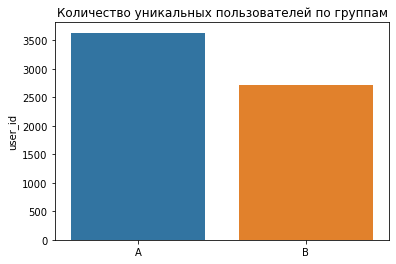

In [30]:
sb.barplot(x=data_full.group.value_counts().index, y=data_full.groupby('group')['user_id'].agg('nunique'))
plt.title('Количество уникальных пользователей по группам')
plt.show()

По количеству уникальных пользователей отличие не критичное, хотя и наблюдается перекос.

## Исследовательский анализ данных

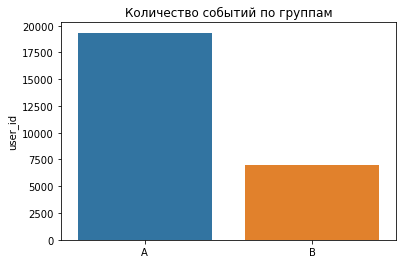

In [31]:
sb.barplot(x=data_full.group.value_counts().index, y=data_full.groupby('group')['user_id'].agg('count'))
plt.title('Количество событий по группам')
plt.show()

По количеству событий очень сильное различие. Возможно, это обусловлено значимыми изменениями в воронке событий.

Взглянем, как число событий в выборках распределено по дням.

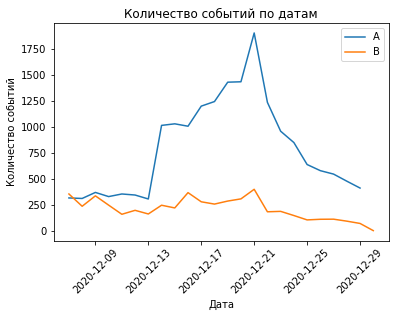

In [32]:
data_full['event_date'] = data_full['event_dt'].dt.date
dataA = data_full.query('group == "A"')
dataB = data_full.query('group == "B"')

plt.plot(dataA.groupby('event_date')['event_name'].agg('count'), label='A')
plt.plot(dataB.groupby('event_date')['event_name'].agg('count'), label='B')
plt.legend()
plt.xticks(rotation = '45')
plt.title('Количество событий по датам')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.show()

Картина идентична той, что мы видели по уникальным пользователям. Резкий рост количества событий по одной из групп в середине теста. Также следует заметить, что начавшаяся 25 декабря маркетинговая акция не повлияла на тестовые группы - как по уникальным пользователям, так и по количеству событий.

Взглянем, как меняется конверсия в воронке в выборках на разных этапах.

In [33]:
events_usersA = (
dataA[['event_name', 'user_id']]
    .groupby('event_name')
    .agg({'user_id': 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
events_usersA.columns = ['event', 'users']
events_usersA['perc_of_users'] = round(events_usersA['users']/dataA['user_id'].nunique() * 100, 1)
display(events_usersA)

events_usersB = (
dataB[['event_name', 'user_id']]
    .groupby('event_name')
    .agg({'user_id': 'nunique'})
    .sort_values(by='user_id', ascending=False)
    .reset_index()
)
events_usersB.columns = ['event', 'users']
events_usersB['perc_of_users'] = round(events_usersB['users']/dataA['user_id'].nunique() * 100, 1)
display(events_usersB)

,event,users,perc_of_users
0,login,2604,71.7
1,product_page,1685,46.4
2,register,1030,28.3
3,purchase,833,22.9
4,product_cart,782,21.5


,event,users,perc_of_users
0,register,1840,50.6
1,login,877,24.1
2,product_page,493,13.6
3,purchase,249,6.9
4,product_cart,244,6.7


В группе В  более 50% пользователей не имеют событий, т.е. по нашему предположению не прошли дальше регистрации. В то же время в группе A таких пользователей 28%. Вообще это очень странно - от 28% до 50% пользователей регистрируются, чтобы не разу не зайти в систему. Либо мы имеем дело с техническими ошибками, когда вход затрудняется по каким-либо причинам, либо у нас серьезные искажения при сборе данных.

В таблице данных у нас есть поле device. Попробуем проанализировать его - возможно, ошибка проявляет себя лишь на одной из платформ.

In [34]:
data_full.pivot_table(index='event_name', columns=['device', 'group'], values='user_id', aggfunc='nunique')

device       Android       Mac        PC      iPhone     
group              A    B    A    B    A    B      A    B
event_name                                               
login           1139  405  255   74  689  212    521  186
product_cart     347  109   81   20  192   56    162   59
product_page     723  233  172   47  450  111    340  102
purchase         358  115   94   22  215   58    166   54
register         451  823   99  176  275  445    205  396

Нет, предположение не подтвердилось. Мы наблюдаем странное поведение пользователей на всех платформах.

Перечислим проблемы проведенного теста, которые следует учитывать при попытке интерпретации результата:
* тест остановлен ранее плановой даты, а он предполагал расчет метрик по пользователям на 14 день пользования сервисом. Или ресурс имеет крайне низкое удержание пользователей - они просто перестали пользоваться сервисом до наступления конечной даты теста.
* существует значительный перекос в количестве событий между группами, однако это могло быть вызвано полученными изменениями в конверсии
* существует небольшой перекос в количестве уникальных пользователей в группах
* значительная часть пользователей, участвующих в тесте - от трети до половины - не имеет событий в логах
* некоторая часть пользователей одновременно участвовала в двух AB-тестах, про технические особенности тестов и возможности их пересечения ничего не известно
* в период проведения теста попадает рожденственская рекламная акция

## Оценка результатов AB-тестирования

Для оценки проведенного теста ожидаемым эффектом из ТЗ произведем дополнительные вычисления:
* Для каждого события рассчитаем срок его возникновения от момента регистрации пользователя;
* Отфильтруем только события, которые произошли в первые 14 дней в соотвествии с ТЗ

In [35]:
data_full['lifetime'] = data_full['event_date'] - data_full['first_date']
data_14_days = data_full[data_full['lifetime'] <= pd.to_timedelta(14, unit='D')]

In [36]:
#Фильтруем данные оставляя только события из ТЗ
events = ['product_page', 'product_cart', 'purchase']
data_14_days = data_14_days.query('event_name in @events')
#Группируем данные в разрезах событий и групп (уникальные пользователи)
result = data_14_days.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
display(result)

group,event_name,A,B
0,product_cart,782,244
1,product_page,1685,493
2,purchase,833,249


Здесь мы видим еще один интересный факт - покупка возможна без добавления в корзину (количество пользователей по событиям покупок выше в обоих группах)

Рассчитываем общее количество пользователей, конверсию которых мы будем сравнивать.

In [37]:
usersA = data_full.query('group == "A"')['user_id'].nunique()
usersB = data_full.query('group == "B"')['user_id'].nunique()
print('база для группы А', usersA)
print('база для группы B', usersB)
#Делим на общее количество пользователей по группам для расчета конверсии
result['conversionA'] = result['A'] / usersA
result['conversionB'] = result['B'] / usersA
#Считаем абсолютные и относительные отклонения
result['absolute'] = result['conversionB'] - result['conversionA']
result['relative'] = round(result['absolute'] / result['conversionA'], 2)
display(result)

база для группы А 3634
база для группы B 2717


group,event_name,A,B,conversionA,conversionB,absolute,relative
0,product_cart,782,244,0.215190,0.067144,-0.148046,-0.69
1,product_page,1685,493,0.463676,0.135663,-0.328013,-0.71
2,purchase,833,249,0.229224,0.068520,-0.160704,-0.70


### Промежуточный вывод
Результат теста - прямо противоположный задуманному. Конверсия в указанные события не только не выросла, но и существенно уменьшилась.

Проверим статистическую разницу долей z-критерием

In [38]:
#создаем функцию для проверки гипотез по z-value
#на вход передаем пары значений с результатами теста
#функция возвращает p-value
def check_stats(col1, col2):
    successes = np.array([col1[0], col2[0]])
    trials = np.array([col1[1], col2[1]])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

Проверим нулевую гипотезу - конверсия уникальных пользователей из события регистрации в интересующие нас события в группах A и B не отличается. Альтернативная гипотеза - они различаются. Будем использовать созданную функцию в цикле.

In [39]:
alpha = .05
for i, row in result.iterrows():
    p_value = check_stats([row['A'], usersA], [row['B'], usersB])
    print(row['event_name'], ' p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

product_cart  p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
product_page  p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
purchase  p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Т.к. мы тестировали несколько гипотез (A/B для трех событий), мы имеем дело с множественным тестом. При его проведении с каждой новой гипотезой возрастает вероятность появления ошибки первого рода (нулевая гипотеза неверно отвергнута).

Для подтверждения результата используем поправку Бонферрони.

Полученный p-value близок к нулю, поэтому здесь поправка ничего не изменит. Однако, рассчитаем ее значение и интерпретируем результат.

При уровне значимости 0.05 и n=3 поправка равна 0.5/3 = 0.0167. При данном уровне значимости все наши нулевые гипотезы отвергаются.

При уровне значимости 0.1 поправка составляет 0.033. При данном уровне значимости все наши нулевые гипотезы также отвергаются.

## Выводы

В данных теста обнаружено большое количество аномалий. Однако, без понимания технической стороны комплектования групп пользователей теста, мы можем лишь косвенно оценивать эти аномалии.

В целом, данные логов подтверждены техническим заданием. Если заказчик уверяет, что они верны и не содержат технических ошибок, мы можем однозначно интерпретировать результат.

В группе В получено статистически значимое уменьшение конверсии пользователей в события, регламентированные ТЗ, вопреки ожидаемому повышению. При условии допущений, изложенных выше, тест можно считать состоявшимся. Ожидаемых улучшений в тестовой группе не произошло.